In [1]:
from qiime2 import Visualization, Artifact, Metadata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from skbio.stats import composition
%matplotlib inline

In [2]:
%cd "/Users/johnsterrett/Research-Projects/Boulder/Chemobrain/200608_Elsayed_Lowry-1101"

/Users/johnsterrett/Research-Projects/Boulder/Chemobrain/200608_Elsayed_Lowry-1101


In [3]:
ls

ANCOM-L2-chemo.qzv                      insertion-tree.qza
ANCOM-L2-hcvsbc.qzv                     jaccard_corr_results.csv
ANCOM-L3-chemo.qzv                      jaccard_sig_Race_Ethnicity-cat/
ANCOM-L3-hcvsbc.qzv                     jaccard_sig_results.csv
ANCOM-L6-hcvsbc.qzv                     lefse_cesd_in.tsv
Cat-meta-no-datetime.txt                lefse_cesd_out.lefse_internal_res
Categorical-meta-noNA.tsv               lefse_cesd_plotdata.csv
Categorical-meta-v3.tsv                 lefse_chemo_in.tsv
CompletedJobInfo.xml*                   lefse_chemo_out.lefse_internal_res
GenerateFASTQRunStatistics.xml*         lefse_chemo_plotdata.csv
HLR-abundances-nona.csv                 lefse_fact_in.tsv
HLR-abundances.csv                      lefse_fact_out.lefse_internal_res
InterOp/                                level-7.csv
L2p/                                    noMito_noChloro-filtered-table.qza
L2p-filtered.qza                        noMito_noChloro-filtered-table.qzv
L3p/       

# Create Input Data

## Drop repeated samples

In [27]:
! qiime feature-table filter-samples \
--i-table noMito_noChloro-filtered-table.qza \
--m-metadata-file Categorical-meta-noNA.tsv \
--o-filtered-table noMito_noChloro-noNA-table.qza

Saved FeatureTable[Frequency] to: noMito_noChloro-noNA-table.qza


## Add taxonomy to feature table

In [28]:
! qiime taxa collapse \
--i-table noMito_noChloro-noNA-table.qza \
--i-taxonomy taxonomy-silva.qza --p-level 7 \
--o-collapsed-table tax-table.qza

Saved FeatureTable[Frequency] to: tax-table.qza


## Load in feature table, make sure index lines up

In [4]:
tax_df = Artifact.load("tax-table.qza")
tax_df = tax_df.view(pd.DataFrame)
tax_df.columns = ["|".join(x.split(";")) for x in tax_df.columns]

In [5]:
for row in tax_df.index:
    tax_df.loc[row] = tax_df.loc[row].apply(lambda x: x/sum(tax_df.loc[row]))

In [6]:
tax_df.head()

,d__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobacterium|__,d__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter|s__Methanobrevibacter_smithii,d__Archaea|p__Thermoplasmatota|c__Thermoplasmata|o__Methanomassiliicoccales|f__Methanomethylophilaceae|__|__,d__Bacteria|__|__|__|__|__|__,d__Bacteria|p__Actinobacteriota|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|__,d__Bacteria|p__Actinobacteriota|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Actinomyces_graevenitzii,d__Bacteria|p__Actinobacteriota|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Schaalia_odontolytica,d__Bacteria|p__Actinobacteriota|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Schaalia_radingae,d__Bacteria|p__Actinobacteriota|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces|s__Winkia_neuii,d__Bacteria|p__Actinobacteriota|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Arcanobacterium|s__Arcanobacterium_sp.,...,d__Bacteria|p__Synergistota|c__Synergistia|o__Synergistales|f__Synergistaceae|g__Jonquetella|s__Jonquetella_anthropi,d__Bacteria|p__Verrucomicrobiota|c__Lentisphaeria|o__Victivallales|f__Victivallaceae|g__Victivallis|__,d__Bacteria|p__Verrucomicrobiota|c__Lentisphaeria|o__Victivallales|f__Victivallaceae|g__Victivallis|s__Victivallis_vadensis,d__Bacteria|p__Verrucomicrobiota|c__Lentisphaeria|o__Victivallales|f__vadinBE97|g__vadinBE97|s__uncultured_rumen,d__Bacteria|p__Verrucomicrobiota|c__Verrucomicrobiae|o__Opitutales|f__Puniceicoccaceae|g__uncultured|s__uncultured_bacterium,d__Bacteria|p__Verrucomicrobiota|c__Verrucomicrobiae|o__Verrucomicrobiales|f__Akkermansiaceae|g__Akkermansia|__,d__Bacteria|p__Verrucomicrobiota|c__Verrucomicrobiae|o__Verrucomicrobiales|f__Akkermansiaceae|g__Akkermansia|s__Akkermansia_muciniphila,d__Bacteria|p__Verrucomicrobiota|c__Verrucomicrobiae|o__Verrucomicrobiales|f__Akkermansiaceae|g__Akkermansia|s__Akkermansia_sp.,d__Bacteria|p__Verrucomicrobiota|c__Verrucomicrobiae|o__Verrucomicrobiales|f__Akkermansiaceae|g__Akkermansia|s__uncultured_organism,d__Eukaryota|p__Basidiomycota|c__Microbotryomycetes|o__Sporidiobolales|f__Sporidiobolaceae|g__Rhodotorula|s__Rhodotorula_mucilaginosa
1,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.00000,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
10,0.000000,0.005351,0.0,0.000048,0.003536,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.00000,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
12,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.00000,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
14,0.000121,0.000000,0.0,0.000000,0.001397,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.00000,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
15,0.000000,0.002961,0.0,0.000039,0.000000,0.0,0.0,0.0,0.000341,0.0,...,0.0,0.00169,0.001376,0.0,0.0,0.0,0.00245,0.0,0.0,0.0


In [7]:
mapping = pd.read_csv("Categorical-meta-noNA.tsv", sep="\t",
                     index_col="sampleid")
mapping = mapping[mapping.iloc[:,1].isna()==False]

In [8]:
print(len(tax_df.index))
print(tax_df.index.dtype)

print(len(mapping.index))
print(mapping.index.dtype)

33
object
33
float64


In [9]:
tax_df.index = tax_df.index.astype(float)

#Make sure the indexes are the same type now
mapping.index.dtype == tax_df.index.dtype

True

In [10]:
#making sure they share all index values
len(set(mapping.index).intersection(tax_df.index)) == len(mapping.index)

True

In [11]:
[x for x in mapping.columns if "cesd_total" in x]

['cesd_total', 'cesd_total_categorical']

## Make input files

### CES-D

In [12]:
lefse_cesd_in = pd.concat([tax_df, 
                           mapping[["participant","cesd_total_categorical"]]],
                         axis=1)
lefse_cesd_in.loc[:,"cesd_total_categorical"] = lefse_cesd_in.loc[:,"cesd_total_categorical"].apply(lambda x: '_'.join(x.split()))

lefse_cesd_in.to_csv("lefse_cesd_in.tsv", sep="\t",index=False)

### FACT-Cog

In [13]:
[x for x in mapping.columns if "fact_c_total" in x]

['fact_c_total', 'fact_c_total_categorical']

In [14]:
lefse_fact_in = pd.concat([tax_df, 
                           mapping[["participant","fact_c_total_categorical"]]],
                         axis=1)
lefse_fact_in.to_csv("lefse_fact_in.tsv", sep="\t",index=False)

In [15]:
sum(mapping["fact_c_total_categorical"].isna()) #these are all NaN???

33

In [16]:
lefse_fact_in = pd.concat([tax_df, 
                           mapping[["participant","fact_c_total"]]],
                         axis=1)

In [17]:
median = np.median(mapping["fact_c_total"])
lefse_fact_in["fact_c_total"] = lefse_fact_in["fact_c_total"].apply(lambda x: "high" if x > median else "low")

lefse_fact_in.to_csv("lefse_fact_in.tsv", sep="\t",index=False)

### Chemo group

In [18]:
lefse_chemo_in = pd.concat([tax_df, 
                           mapping[["participant","hcvsbc-cat"]]],
                         axis=1)
lefse_chemo_in.to_csv("lefse_chemo_in.tsv", sep="\t",index=False)

# Results

In [47]:
lefse = pd.read_csv("lefse_cesd_out.lefse_internal_res", 
                    sep="\t", 
                    header=None)

lefse.rename(mapper={0: "Bacteria",
                     1: "Log10(highest class average)",
                     2: "Highest Class",
                     3: "LDA Score (log10)",
                     4: "p value"},
             axis=1, inplace=True)

In [48]:
def split_taxlevel(x, splitter="__"):
    mapper={"d":"domain",
            "k":"kingdom",
            "p":"phylum",
            "c":"class",
            "o":"order",
            "f":"family",
            "g":"genus",
            "s":"species"}
    
    return ": ".join([mapper[x.split(splitter)[0]],x.split(splitter)[-1]])

def make_plotnames(x):
    
    try: 
        name = split_taxlevel(x.split(".")[-1])
        level = -1
    except KeyError:
        try:
            name = split_taxlevel(x.split(".")[-2])
            level = -2
        except KeyError:
            try:
                name = split_taxlevel(x.split(".")[-3])
                level = -3
            except KeyError:
                try:
                    name = split_taxlevel(x.split(".")[-4])
                    level = -4
                except KeyError:
                    name = np.nan
                    
    if name in ['species: ','species: uncultured_organism',
                'species: uncultured_marine','species: gut_metagenome',
                'species: human_gut', 'species: metagenome', 
                'species: unidentified']:
        name = split_taxlevel(x.split(".")[-2])

    if any(x in str(name) for x in ['uncultured', 'unidentified']):
        level = level-1
        name = split_taxlevel(x.split(".")[level])
    
    #if str(name).contains('uncultured'):
    #    level = level - 1
    #    name = split_taxlevel(x.split(".")[level])
    
    if name in ['genus: ', 'genus: uncultured']:
        name = split_taxlevel(x.split(".")[-3])
        
        
    return name

In [49]:
#filter only significant results
lefse = lefse.loc[lefse["Highest Class"].isna()==False]

#apply plotnames
lefse.loc[:,"plotnames"] = lefse.loc[:,"Bacteria"].apply(func=lambda x: make_plotnames(x))

In [50]:
def taxonomy_splitter(fulltax, splitter="; "):
    fulltax = [x[3:] for x in fulltax.split(splitter)]
    try:
        domain = fulltax[0]
    except IndexError:
        domain = 'NA'
        
    try:
        phylum = fulltax[1]
    except IndexError:
        phylum = 'NA'
        
    try:
        clas = fulltax[2]
    except IndexError:
        clas = 'NA'
    
    try:
        order = fulltax[3]
    except IndexError:
        order = 'NA'
        
    try:
        family = fulltax[4]
    except IndexError:
        family = 'NA'
        
    try:
        genus = fulltax[5]
    except IndexError:
        genus = 'NA'
    
    try:
        species = fulltax[6]
    except IndexError:
        species = 'NA'
        
    return domain, phylum, clas, order, family, genus, species

In [51]:
lefse.loc[:,'tax_split'] =lefse.loc[:,'Bacteria'].apply(taxonomy_splitter, splitter=".")

lefse.loc[:,'Domain'] = lefse.loc[:,'tax_split'].apply(lambda x: x[0])
lefse.loc[:,'Phylum'] = lefse.loc[:,'tax_split'].apply(lambda x: x[1])
lefse.loc[:,'Class'] = lefse.loc[:,'tax_split'].apply(lambda x: x[2])
lefse.loc[:,'Order'] = lefse.loc[:,'tax_split'].apply(lambda x: x[3])
lefse.loc[:,'Family'] = lefse.loc[:,'tax_split'].apply(lambda x: x[4])
lefse.loc[:,'Genus'] = lefse.loc[:,'tax_split'].apply(lambda x: x[5])
lefse.loc[:,'Species'] = lefse.loc[:,'tax_split'].apply(lambda x: x[6])
lefse.drop('tax_split', axis=1, inplace=True)

lefse.loc[lefse["Highest Class"]=="Possible_Depression","LDA Score (log10)"] = lefse.loc[lefse["Highest Class"]=="Possible_Depression","LDA Score (log10)"].apply(lambda x: -1*x)

lefse.sort_values("LDA Score (log10)", ascending=False, inplace=True)


In [52]:
lefse = lefse[lefse["plotnames"]!="domain: Bacteria"]

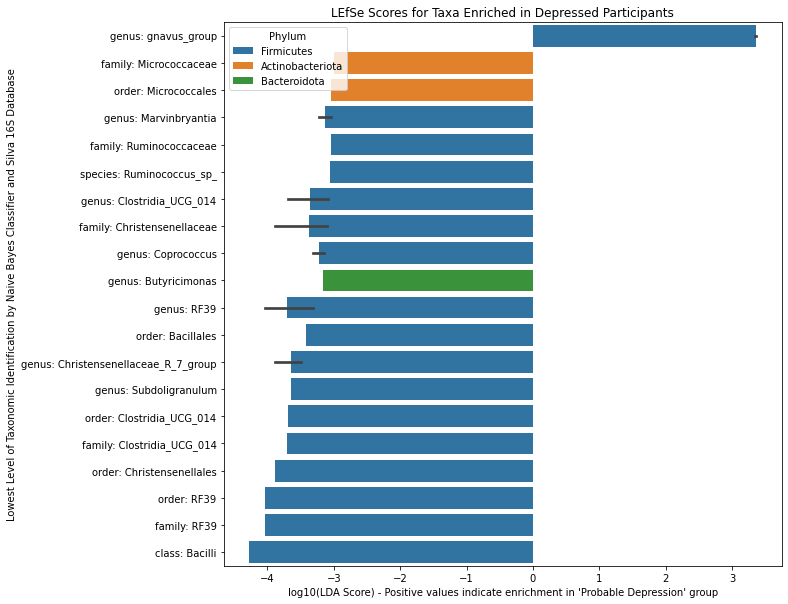

In [53]:
ax = sns.barplot(y="plotnames",
                 x="LDA Score (log10)",
                 hue = "Phylum",
                 data = lefse.loc[(lefse["LDA Score (log10)"] < -3) | (lefse["LDA Score (log10)"] > 2.5)], 
                 dodge=False,)

ax.set_ylabel("Lowest Level of Taxonomic Identification by Naive Bayes Classifier and Silva 16S Database")
ax.set_title("LEfSe Scores for Taxa Enriched in Depressed Participants")
ax.set_xlabel("log10(LDA Score) - Positive values indicate enrichment in 'Probable Depression' group")
plt.gcf().set_size_inches(10,10)
plt.savefig("CESD-LEfSe.pdf")
plt.show()


In [54]:
lefse = lefse[lefse["plotnames"].isna()==False]

In [55]:
cesdlefse = lefse

In [56]:
lefse.to_csv("lefse_cesd_plotdata.csv")

# Chemo Results

In [57]:
lefse = pd.read_csv("lefse_chemo_out.lefse_internal_res", 
                    sep="\t", 
                    header=None)

lefse.rename(mapper={0: "Bacteria",
                     1: "Log10(highest class average)",
                     2: "Highest Class",
                     3: "LDA Score (log10)",
                     4: "p value"},
             axis=1, inplace=True)

In [58]:
#filter only significant results
lefse = lefse.loc[lefse["Highest Class"].isna()==False]

#apply plotnames
lefse.loc[:,"plotnames"] = lefse.loc[:,"Bacteria"].apply(func=lambda x: make_plotnames(x))

In [59]:
lefse.loc[:,'tax_split'] =lefse.loc[:,'Bacteria'].apply(taxonomy_splitter, splitter=".")

lefse.loc[:,'Domain'] = lefse.loc[:,'tax_split'].apply(lambda x: x[0])
lefse.loc[:,'Phylum'] = lefse.loc[:,'tax_split'].apply(lambda x: x[1])
lefse.loc[:,'Class'] = lefse.loc[:,'tax_split'].apply(lambda x: x[2])
lefse.loc[:,'Order'] = lefse.loc[:,'tax_split'].apply(lambda x: x[3])
lefse.loc[:,'Family'] = lefse.loc[:,'tax_split'].apply(lambda x: x[4])
lefse.loc[:,'Genus'] = lefse.loc[:,'tax_split'].apply(lambda x: x[5])
lefse.loc[:,'Species'] = lefse.loc[:,'tax_split'].apply(lambda x: x[6])
lefse.drop('tax_split', axis=1, inplace=True)

lefse.loc[lefse["Highest Class"]=="2 - No","LDA Score (log10)"] = lefse.loc[lefse["Highest Class"]=="2 - No","LDA Score (log10)"].apply(lambda x: -1*x)

lefse.sort_values("LDA Score (log10)", ascending=False, inplace=True)


In [60]:
lefse = lefse.loc[lefse["plotnames"]!="genus: coprostanoligenes_group"]

In [61]:
lefse.loc[(lefse["LDA Score (log10)"] < -2.5) | (lefse["LDA Score (log10)"] > 2)]

,Bacteria,Log10(highest class average),Highest Class,LDA Score (log10),p value,plotnames,Domain,Phylum,Class,Order,Family,Genus,Species
107,d__Bacteria.p__Bacteroidota.c__Bacteroidia.o__...,4.298953,1 - Yes,4.096631,0.0410394676386,genus: Prevotellaceae_NK3B31_group,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Prevotellaceae,Prevotellaceae_NK3B31_group,
595,d__Bacteria.p__Bacteroidota.c__Bacteroidia.o__...,3.749163,1 - Yes,3.488088,0.0214007185983,species: Bacteroides_caccae,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,Bacteroides_caccae
225,d__Bacteria.p__Firmicutes.c__Clostridia.o__Lac...,3.373233,1 - Yes,3.121933,0.0410394676386,genus: Moryella,Bacteria,Firmicutes,Clostridia,Lachnospirales,Lachnospiraceae,Moryella,uncultured_organism
31,d__Bacteria.p__Proteobacteria.c__Gammaproteoba...,3.314307,1 - Yes,2.974844,0.0161133635427,family: Pasteurellaceae,Bacteria,Proteobacteria,Gammaproteobacteria,Pasteurellales,Pasteurellaceae,NA,NA
320,d__Bacteria.p__Proteobacteria.c__Gammaproteoba...,3.314307,1 - Yes,2.963400,0.0161133635427,order: Pasteurellales,Bacteria,Proteobacteria,Gammaproteobacteria,Pasteurellales,NA,NA,NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...
701,d__Bacteria.p__Firmicutes.c__Clostridia.o__Clo...,4.071702,2 - No,-3.797132,0.0435224810006,order: Clostridia_UCG_014,Bacteria,Firmicutes,Clostridia,Clostridia_UCG_014,NA,NA,NA
854,d__Bacteria.p__Firmicutes.c__Clostridia.o__Clo...,4.071702,2 - No,-3.798453,0.0435224810006,family: Clostridia_UCG_014,Bacteria,Firmicutes,Clostridia,Clostridia_UCG_014,Clostridia_UCG_014,NA,NA
1145,d__Bacteria.p__Firmicutes.c__Clostridia.o__Clo...,4.071702,2 - No,-3.799481,0.0435224810006,genus: Clostridia_UCG_014,Bacteria,Firmicutes,Clostridia,Clostridia_UCG_014,Clostridia_UCG_014,Clostridia_UCG_014,NA
636,d__Bacteria.p__Bacteroidota.c__Bacteroidia.o__...,4.599334,2 - No,-3.946347,0.0204388003323,genus: Prevotella,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Prevotellaceae,Prevotella,NA


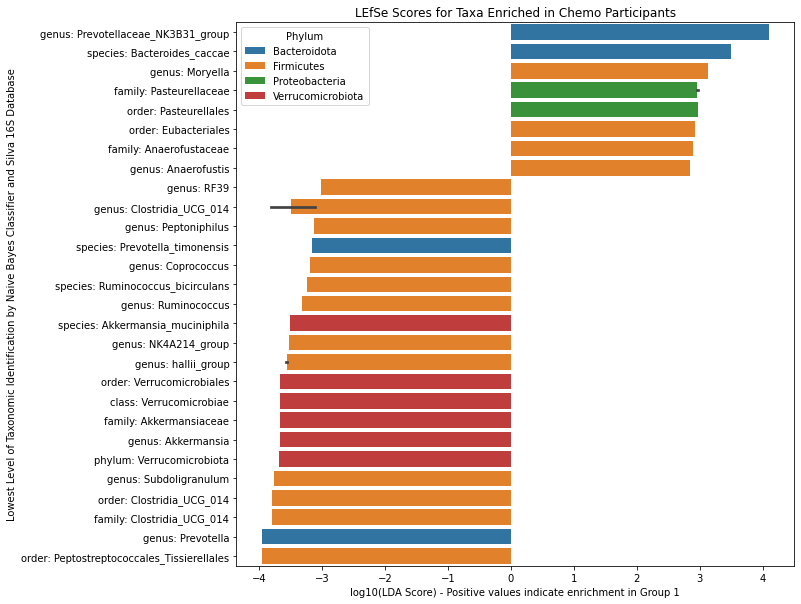

In [62]:
ax = sns.barplot(y="plotnames",
                 x="LDA Score (log10)",
                 hue = "Phylum",
                 data = lefse.loc[(lefse["LDA Score (log10)"] < -3) | (lefse["LDA Score (log10)"] > 2)], 
                 dodge=False,)

ax.set_ylabel("Lowest Level of Taxonomic Identification by Naive Bayes Classifier and Silva 16S Database")
ax.set_title("LEfSe Scores for Taxa Enriched in Chemo Participants")
ax.set_xlabel("log10(LDA Score) - Positive values indicate enrichment in Group 1")
plt.gcf().set_size_inches(10,10)
plt.savefig("Chemo-LEfSe.pdf")
plt.show()


In [63]:
chemolefse = lefse

In [64]:
lefse.to_csv("lefse_chemo_plotdata.csv")

## Fact-Cog

In [65]:
lefse = pd.read_csv("lefse_fact_out.lefse_internal_res", 
                    sep="\t", 
                    header=None)

lefse.rename(mapper={0: "Bacteria",
                     1: "Log10(highest class average)",
                     2: "Highest Class",
                     3: "LDA Score (log10)",
                     4: "p value"},
             axis=1, inplace=True)

In [66]:
#filter only significant results
lefse = lefse.loc[lefse["Highest Class"].isna()==False]

#apply plotnames
lefse.loc[:,"plotnames"] = lefse.loc[:,"Bacteria"].apply(func=lambda x: make_plotnames(x))

In [67]:
lefse.loc[:,'tax_split'] =lefse.loc[:,'Bacteria'].apply(taxonomy_splitter, splitter=".")

lefse.loc[:,'Domain'] = lefse.loc[:,'tax_split'].apply(lambda x: x[0])
lefse.loc[:,'Phylum'] = lefse.loc[:,'tax_split'].apply(lambda x: x[1])
lefse.loc[:,'Class'] = lefse.loc[:,'tax_split'].apply(lambda x: x[2])
lefse.loc[:,'Order'] = lefse.loc[:,'tax_split'].apply(lambda x: x[3])
lefse.loc[:,'Family'] = lefse.loc[:,'tax_split'].apply(lambda x: x[4])
lefse.loc[:,'Genus'] = lefse.loc[:,'tax_split'].apply(lambda x: x[5])
lefse.loc[:,'Species'] = lefse.loc[:,'tax_split'].apply(lambda x: x[6])
lefse.drop('tax_split', axis=1, inplace=True)

lefse.loc[lefse["Highest Class"]=="low","LDA Score (log10)"] = lefse.loc[lefse["Highest Class"]=="low","LDA Score (log10)"].apply(lambda x: -1*x)

lefse.sort_values("LDA Score (log10)", ascending=False, inplace=True)


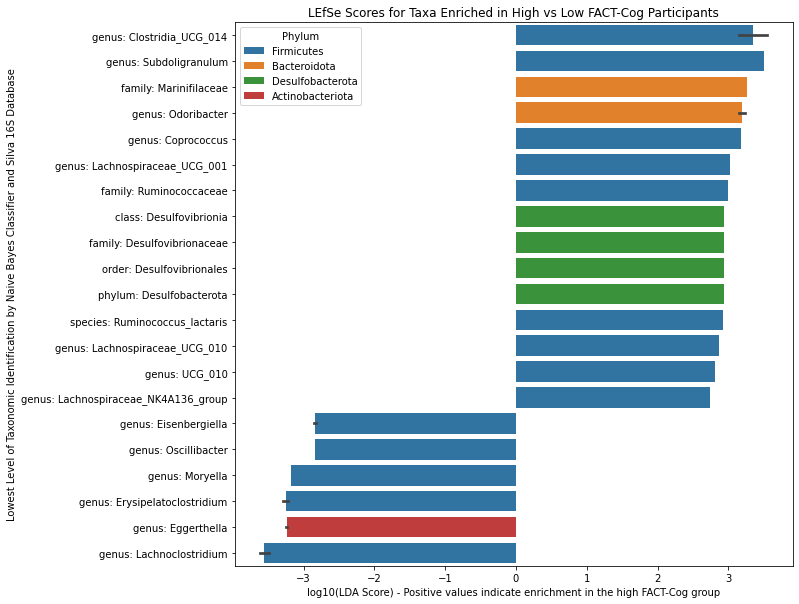

In [68]:
ax = sns.barplot(y="plotnames",
                 x="LDA Score (log10)",
                 hue = "Phylum",
                 data = lefse.loc[(lefse["LDA Score (log10)"] < -2) | (lefse["LDA Score (log10)"] > 2)], 
                 dodge=False,)

ax.set_ylabel("Lowest Level of Taxonomic Identification by Naive Bayes Classifier and Silva 16S Database")
ax.set_title("LEfSe Scores for Taxa Enriched in High vs Low FACT-Cog Participants")
ax.set_xlabel("log10(LDA Score) - Positive values indicate enrichment in the high FACT-Cog group")
plt.gcf().set_size_inches(10,10)
plt.savefig("FACT-LEfSe.pdf")
plt.show()

# Finding common microbes

/opt/anaconda3/envs/qiime2-2020.11/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/anaconda3/envs/qiime2-2020.11/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


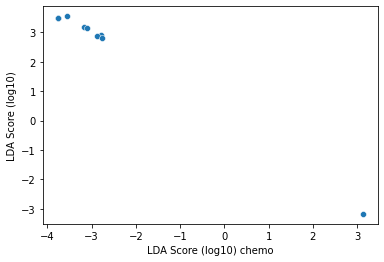

In [69]:
shared = list(set(lefse["Bacteria"]).intersection(set(chemolefse["Bacteria"])))

fact_chemo = lefse.loc[lefse["Bacteria"].apply(lambda x: x in shared)]
fact_chemo.loc[:,"Chemo_cat"] = chemolefse.loc[:,"Highest Class"]
fact_chemo.loc[:,"LDA Score (log10) chemo"] = chemolefse.loc[:,"LDA Score (log10)"]

scatter = fact_chemo[["Bacteria","LDA Score (log10)","LDA Score (log10) chemo", "plotnames"]]

ax = sns.scatterplot(x="LDA Score (log10) chemo",
                     y="LDA Score (log10)",
                     data=scatter)

/opt/anaconda3/envs/qiime2-2020.11/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/anaconda3/envs/qiime2-2020.11/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


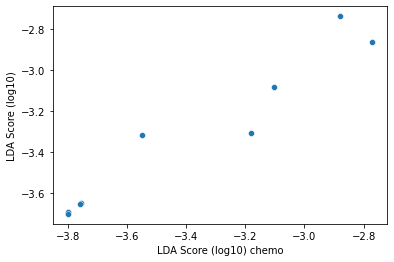

In [70]:
shared = list(set(cesdlefse["Bacteria"]).intersection(set(chemolefse["Bacteria"])))

cesd_chemo = cesdlefse.loc[cesdlefse["Bacteria"].apply(lambda x: x in shared)]
cesd_chemo.loc[:,"Chemo_cat"] = chemolefse.loc[:,"Highest Class"]
cesd_chemo.loc[:,"LDA Score (log10) chemo"] = chemolefse.loc[:,"LDA Score (log10)"]

scatter = cesd_chemo[["Bacteria","LDA Score (log10)","LDA Score (log10) chemo", "plotnames"]]

ax = sns.scatterplot(x="LDA Score (log10) chemo",
                     y="LDA Score (log10)",
                     data=scatter)

/opt/anaconda3/envs/qiime2-2020.11/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/anaconda3/envs/qiime2-2020.11/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


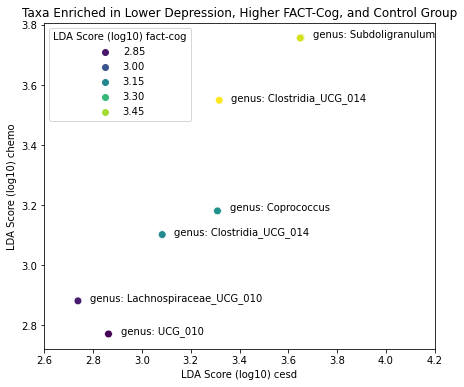

In [71]:
shared = set(lefse["Bacteria"]).intersection(set(chemolefse["Bacteria"])).intersection(cesdlefse["Bacteria"])

allshared = lefse.loc[lefse["Bacteria"].apply(lambda x: x in shared)]

allshared.loc[:,"Chemo_cat"] = chemolefse.loc[:,"Highest Class"]
allshared.loc[:,"LDA Score (log10) chemo"] = chemolefse.loc[:,"LDA Score (log10)"].apply(lambda x: x*-1)

allshared.loc[:,"Chemo_cesd"] = cesdlefse.loc[:,"Highest Class"]
allshared.loc[:,"LDA Score (log10) cesd"] = cesdlefse.loc[:,"LDA Score (log10)"].apply(lambda x: x*-1)

allshared.loc[:,"LDA Score (log10) fact-cog"] = allshared.loc[:,"LDA Score (log10)"]



ax = sns.scatterplot(x="LDA Score (log10) cesd",
                    y="LDA Score (log10) chemo",
                    hue="LDA Score (log10) fact-cog",
                    data=allshared,
                    palette="viridis",
                    s=60)
ax.set_title("Taxa Enriched in Lower Depression, Higher FACT-Cog, and Control Group")

#Adding bacteria names, drop 671 was to prevent slightly offset repeat of "genus: Subdoligranulum"
for i, bac in enumerate(allshared.drop(671)["plotnames"]):
    plt.text(x=allshared.drop(671)["LDA Score (log10) cesd"].iloc[i]+0.05,
             y=allshared.drop(671)["LDA Score (log10) chemo"].iloc[i],
             s=bac)

ax.set_xlim(2.6,4.2)
plt.gcf().set_size_inches(7,6)
plt.show()

#fig = plt.figure()
#ax = fig.add_subplot(projection='3d')

#ax.plot(xs=allshared.loc[:,"LDA Score (log10) cesd"],
#        ys=allshared.loc[:,"LDA Score (log10) chemo"],
#        zs=allshared.loc[:,"LDA Score (log10)"],
#        marker="o")

In [240]:
allshared

,Bacteria,Log10(highest class average),Highest Class,LDA Score (log10),p value,plotnames,Domain,Phylum,Class,Order,Family,Genus,Species,Chemo_cat,LDA Score (log10) chemo,Chemo_cesd,LDA Score (log10) cesd,LDA Score (log10) fact-cog
53,d__Bacteria.p__Firmicutes.c__Clostridia.o__Clo...,3.778722,high,3.549433,0.0141849434845,genus: Clostridia_UCG_014,Bacteria,Firmicutes,Clostridia,Clostridia_UCG_014,Clostridia_UCG_014,Clostridia_UCG_014,,2 - No,3.548925,Possible_Depression,3.316972,3.549433
259,d__Bacteria.p__Firmicutes.c__Clostridia.o__Osc...,4.200195,high,3.501775,0.0251357643071,genus: Subdoligranulum,Bacteria,Firmicutes,Clostridia,Oscillospirales,Ruminococcaceae,Subdoligranulum,NA,2 - No,3.757990,Possible_Depression,3.651827,3.501775
671,d__Bacteria.p__Firmicutes.c__Clostridia.o__Osc...,4.199176,high,3.499730,0.0251357643071,genus: Subdoligranulum,Bacteria,Firmicutes,Clostridia,Oscillospirales,Ruminococcaceae,Subdoligranulum,,2 - No,3.756117,Possible_Depression,3.648870,3.499730
11,d__Bacteria.p__Firmicutes.c__Clostridia.o__Lac...,3.769446,high,3.178360,0.0186346707912,genus: Coprococcus,Bacteria,Firmicutes,Clostridia,Lachnospirales,Lachnospiraceae,Coprococcus,NA,2 - No,3.180847,Possible_Depression,3.309755,3.178360
250,d__Bacteria.p__Firmicutes.c__Clostridia.o__Clo...,3.307702,high,3.155453,0.00912455670065,genus: Clostridia_UCG_014,Bacteria,Firmicutes,Clostridia,Clostridia_UCG_014,Clostridia_UCG_014,Clostridia_UCG_014,uncultured_Acetivibrio,2 - No,3.102056,Possible_Depression,3.083465,3.155453
45,d__Bacteria.p__Firmicutes.c__Clostridia.o__Lac...,2.586020,high,2.863071,0.0217081946356,genus: Lachnospiraceae_UCG_010,Bacteria,Firmicutes,Clostridia,Lachnospirales,Lachnospiraceae,Lachnospiraceae_UCG_010,uncultured_organism,2 - No,2.881420,Possible_Depression,2.738264,2.863071
850,d__Bacteria.p__Firmicutes.c__Clostridia.o__Osc...,2.983600,high,2.806075,0.00818573249914,genus: UCG_010,Bacteria,Firmicutes,Clostridia,Oscillospirales,UCG_010,UCG_010,uncultured_bacterium,2 - No,2.771279,Possible_Depression,2.863329,2.806075


In [241]:
[x for x in allshared["Bacteria"]]

['d__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridia_UCG_014.f__Clostridia_UCG_014.g__Clostridia_UCG_014.__',
 'd__Bacteria.p__Firmicutes.c__Clostridia.o__Oscillospirales.f__Ruminococcaceae.g__Subdoligranulum',
 'd__Bacteria.p__Firmicutes.c__Clostridia.o__Oscillospirales.f__Ruminococcaceae.g__Subdoligranulum.__',
 'd__Bacteria.p__Firmicutes.c__Clostridia.o__Lachnospirales.f__Lachnospiraceae.g__Coprococcus',
 'd__Bacteria.p__Firmicutes.c__Clostridia.o__Clostridia_UCG_014.f__Clostridia_UCG_014.g__Clostridia_UCG_014.s__uncultured_Acetivibrio',
 'd__Bacteria.p__Firmicutes.c__Clostridia.o__Lachnospirales.f__Lachnospiraceae.g__Lachnospiraceae_UCG_010.s__uncultured_organism',
 'd__Bacteria.p__Firmicutes.c__Clostridia.o__Oscillospirales.f__UCG_010.g__UCG_010.s__uncultured_bacterium']

Cool! The bacteria listed above are enriched in the controls, lower depression group, and . . . high fact cog? I thought emily said higher fact cog was associated with more dysfunction? **CORRECTION** high fact cog is better functioning!

In [243]:
alls = lefse[["Bacteria", "plotnames","Highest Class", "LDA Score (log10)"]]

alls.loc[:,"Chemo_cat"] = chemolefse.loc[:,"Highest Class"]
alls.loc[:,"LDA Score (log10) chemo"] = chemolefse.loc[:,"LDA Score (log10)"]

alls.loc[:,"Cesd_cat"] = cesdlefse.loc[:,"Highest Class"]
alls.loc[:,"LDA Score (log10) cesd"] = cesdlefse.loc[:,"LDA Score (log10)"]

alls.loc[:,"LDA Score (log10) fact cog"] = lefse.loc[:,"LDA Score (log10)"].apply(lambda x: x*-1)

alls.set_index("plotnames",inplace=True)

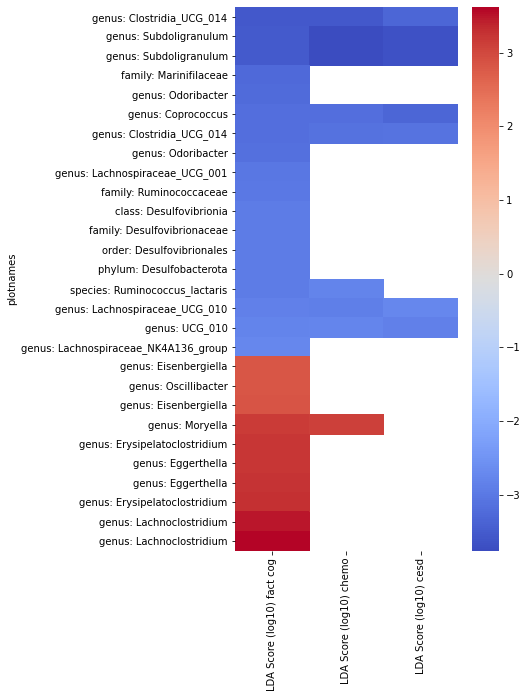

In [244]:
sns.heatmap(alls[["LDA Score (log10) fact cog", "LDA Score (log10) chemo", "LDA Score (log10) cesd"]],
            cmap="coolwarm",
           yticklabels=True)
plt.gcf().set_size_inches(5,10)
plt.show()

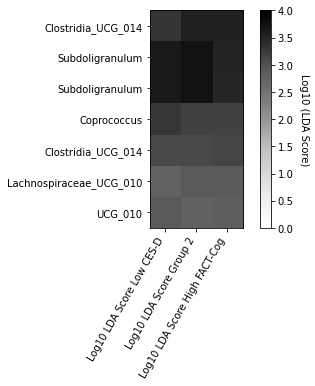

In [109]:
plt.imshow(allshared[["LDA Score (log10) cesd","LDA Score (log10) chemo","LDA Score (log10) fact-cog"]],
          cmap="Greys")
plt.clim(0,4)
plt.yticks(range(allshared.shape[0]), [x.split(" ")[-1] for x in allshared["plotnames"]])
plt.xticks(range(3), ["Low CES-D", "Log10 LDA Score Group 2", "Log10 LDA Score High FACT-Cog"],
          rotation=60, ha="right")
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel("Log10 (LDA Score)", rotation=270)
plt.show()

In [245]:
pd.concat([lefse[["plotnames", "Highest Class", "LDA Score (log10)"]],
            chemolefse.loc[:,["Highest Class", "LDA Score (log10)"]],
            cesdlefse.loc[:,["Highest Class", "LDA Score (log10)"]]],
         axis=1)

,plotnames,Highest Class,LDA Score (log10),Highest Class,LDA Score (log10),Highest Class,LDA Score (log10)
11,genus: Coprococcus,high,3.178360,2 - No,-3.180847,Possible_Depression,-3.309755
12,NaN,NaN,NaN,NaN,NaN,Possible_Depression,-2.752667
20,NaN,NaN,NaN,2 - No,-3.505035,NaN,NaN
30,NaN,NaN,NaN,2 - No,-2.738275,NaN,NaN
31,NaN,NaN,NaN,1 - Yes,2.974844,NaN,NaN
...,...,...,...,...,...,...,...
1118,genus: Eggerthella,low,-3.238075,NaN,NaN,NaN,NaN
1128,class: Desulfovibrionia,high,2.941570,NaN,NaN,NaN,NaN
1144,genus: Odoribacter,high,3.148965,NaN,NaN,NaN,NaN
1145,NaN,NaN,NaN,2 - No,-3.799481,Possible_Depression,-3.694472


## Getting relative abundances

In [246]:
allshared.loc[:,"Bacteria"] = allshared.loc[:,"Bacteria"].apply(lambda x: "|".join(x.split(".")))

In [247]:
def fixtax(string):
    while sum("|"==c for c in string) < 6:
        string+="|__"
    return string

allshared.loc[:,"AltBacteria"] = allshared.loc[:,"Bacteria"].apply(fixtax)


[x for x in allshared["AltBacteria"]]

['d__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridia_UCG_014|f__Clostridia_UCG_014|g__Clostridia_UCG_014|__',
 'd__Bacteria|p__Firmicutes|c__Clostridia|o__Oscillospirales|f__Ruminococcaceae|g__Subdoligranulum|__',
 'd__Bacteria|p__Firmicutes|c__Clostridia|o__Oscillospirales|f__Ruminococcaceae|g__Subdoligranulum|__',
 'd__Bacteria|p__Firmicutes|c__Clostridia|o__Lachnospirales|f__Lachnospiraceae|g__Coprococcus|__',
 'd__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridia_UCG_014|f__Clostridia_UCG_014|g__Clostridia_UCG_014|s__uncultured_Acetivibrio',
 'd__Bacteria|p__Firmicutes|c__Clostridia|o__Lachnospirales|f__Lachnospiraceae|g__Lachnospiraceae_UCG_010|s__uncultured_organism',
 'd__Bacteria|p__Firmicutes|c__Clostridia|o__Oscillospirales|f__UCG_010|g__UCG_010|s__uncultured_bacterium']

In [248]:
tax_df.loc[:,allshared["AltBacteria"]]

/opt/anaconda3/envs/qiime2-2020.6-NEW/lib/python3.6/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,d__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridia_UCG_014|f__Clostridia_UCG_014|g__Clostridia_UCG_014|__,d__Bacteria|p__Firmicutes|c__Clostridia|o__Oscillospirales|f__Ruminococcaceae|g__Subdoligranulum|__,d__Bacteria|p__Firmicutes|c__Clostridia|o__Oscillospirales|f__Ruminococcaceae|g__Subdoligranulum|__,d__Bacteria|p__Firmicutes|c__Clostridia|o__Lachnospirales|f__Lachnospiraceae|g__Coprococcus|__,d__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridia_UCG_014|f__Clostridia_UCG_014|g__Clostridia_UCG_014|s__uncultured_Acetivibrio,d__Bacteria|p__Firmicutes|c__Clostridia|o__Lachnospirales|f__Lachnospiraceae|g__Lachnospiraceae_UCG_010|s__uncultured_organism,d__Bacteria|p__Firmicutes|c__Clostridia|o__Oscillospirales|f__UCG_010|g__UCG_010|s__uncultured_bacterium
1.0,NaN,0.024765,0.024765,0.000000,NaN,NaN,NaN
10.0,NaN,0.012088,0.012088,0.000000,NaN,NaN,NaN
12.0,NaN,0.007611,0.007611,0.000000,NaN,NaN,NaN
14.0,NaN,0.029268,0.029268,0.004873,NaN,NaN,NaN
15.0,NaN,0.015240,0.015240,0.004678,NaN,NaN,NaN
17.0,NaN,0.005910,0.005910,0.002932,NaN,NaN,NaN
19.0,NaN,0.036881,0.036881,0.007126,NaN,NaN,NaN
21.0,NaN,0.000000,0.000000,0.002542,NaN,NaN,NaN
22.0,NaN,0.002001,0.002001,0.000000,NaN,NaN,NaN
23.0,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN


I'm not quite sure what LEfSe is doing, but there are some LEfSe output bacteria that aren't present in our input data. I guess it groups by taxonomic level.

In [249]:
[x for x in allshared["Bacteria"]]

['d__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridia_UCG_014|f__Clostridia_UCG_014|g__Clostridia_UCG_014|__',
 'd__Bacteria|p__Firmicutes|c__Clostridia|o__Oscillospirales|f__Ruminococcaceae|g__Subdoligranulum',
 'd__Bacteria|p__Firmicutes|c__Clostridia|o__Oscillospirales|f__Ruminococcaceae|g__Subdoligranulum|__',
 'd__Bacteria|p__Firmicutes|c__Clostridia|o__Lachnospirales|f__Lachnospiraceae|g__Coprococcus',
 'd__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridia_UCG_014|f__Clostridia_UCG_014|g__Clostridia_UCG_014|s__uncultured_Acetivibrio',
 'd__Bacteria|p__Firmicutes|c__Clostridia|o__Lachnospirales|f__Lachnospiraceae|g__Lachnospiraceae_UCG_010|s__uncultured_organism',
 'd__Bacteria|p__Firmicutes|c__Clostridia|o__Oscillospirales|f__UCG_010|g__UCG_010|s__uncultured_bacterium']

In [250]:
for col in tax_df.columns:
    for tax in allshared["Bacteria"]:
        if col.startswith(tax):
            print(col)

d__Bacteria|p__Firmicutes|c__Clostridia|o__Lachnospirales|f__Lachnospiraceae|g__Coprococcus|__
d__Bacteria|p__Firmicutes|c__Clostridia|o__Lachnospirales|f__Lachnospiraceae|g__Coprococcus|s__Coprococcus_eutactus
d__Bacteria|p__Firmicutes|c__Clostridia|o__Lachnospirales|f__Lachnospiraceae|g__Coprococcus|s__Lachnospiraceae_bacterium
d__Bacteria|p__Firmicutes|c__Clostridia|o__Lachnospirales|f__Lachnospiraceae|g__Coprococcus|s__metagenome
d__Bacteria|p__Firmicutes|c__Clostridia|o__Oscillospirales|f__Ruminococcaceae|g__Subdoligranulum|__
d__Bacteria|p__Firmicutes|c__Clostridia|o__Oscillospirales|f__Ruminococcaceae|g__Subdoligranulum|__
d__Bacteria|p__Firmicutes|c__Clostridia|o__Oscillospirales|f__Ruminococcaceae|g__Subdoligranulum|s__uncultured_Ruminococcaceae


**Looks like LEfSe replaces dashes with undercores, which is why the UCG weren't showing up**

In [255]:
allshared.loc[:,"AltBacteria"] = allshared.loc[:,"AltBacteria"].apply(lambda x: "UCG-".join(x.split("UCG_")))

Dropping #259, which is a repeat subdoligranulum in order to not have it show up in the relative abundances

In [291]:
allshared.drop(259)

,Bacteria,Log10(highest class average),Highest Class,LDA Score (log10),p value,plotnames,Domain,Phylum,Class,Order,Family,Genus,Species,Chemo_cat,LDA Score (log10) chemo,Chemo_cesd,LDA Score (log10) cesd,LDA Score (log10) fact-cog,AltBacteria
53,d__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,3.778722,high,3.549433,0.0141849434845,genus: Clostridia_UCG_014,Bacteria,Firmicutes,Clostridia,Clostridia_UCG_014,Clostridia_UCG_014,Clostridia_UCG_014,,2 - No,3.548925,Possible_Depression,3.316972,3.549433,d__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...
671,d__Bacteria|p__Firmicutes|c__Clostridia|o__Osc...,4.199176,high,3.499730,0.0251357643071,genus: Subdoligranulum,Bacteria,Firmicutes,Clostridia,Oscillospirales,Ruminococcaceae,Subdoligranulum,,2 - No,3.756117,Possible_Depression,3.648870,3.499730,d__Bacteria|p__Firmicutes|c__Clostridia|o__Osc...
11,d__Bacteria|p__Firmicutes|c__Clostridia|o__Lac...,3.769446,high,3.178360,0.0186346707912,genus: Coprococcus,Bacteria,Firmicutes,Clostridia,Lachnospirales,Lachnospiraceae,Coprococcus,NA,2 - No,3.180847,Possible_Depression,3.309755,3.178360,d__Bacteria|p__Firmicutes|c__Clostridia|o__Lac...
250,d__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...,3.307702,high,3.155453,0.00912455670065,genus: Clostridia_UCG_014,Bacteria,Firmicutes,Clostridia,Clostridia_UCG_014,Clostridia_UCG_014,Clostridia_UCG_014,uncultured_Acetivibrio,2 - No,3.102056,Possible_Depression,3.083465,3.155453,d__Bacteria|p__Firmicutes|c__Clostridia|o__Clo...
45,d__Bacteria|p__Firmicutes|c__Clostridia|o__Lac...,2.586020,high,2.863071,0.0217081946356,genus: Lachnospiraceae_UCG_010,Bacteria,Firmicutes,Clostridia,Lachnospirales,Lachnospiraceae,Lachnospiraceae_UCG_010,uncultured_organism,2 - No,2.881420,Possible_Depression,2.738264,2.863071,d__Bacteria|p__Firmicutes|c__Clostridia|o__Lac...
850,d__Bacteria|p__Firmicutes|c__Clostridia|o__Osc...,2.983600,high,2.806075,0.00818573249914,genus: UCG_010,Bacteria,Firmicutes,Clostridia,Oscillospirales,UCG_010,UCG_010,uncultured_bacterium,2 - No,2.771279,Possible_Depression,2.863329,2.806075,d__Bacteria|p__Firmicutes|c__Clostridia|o__Osc...


In [292]:
sharedtax = tax_df.loc[:,allshared.drop(259)["AltBacteria"]]

/opt/anaconda3/envs/qiime2-2020.6-NEW/lib/python3.6/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/qiime2-2020.6-NEW/lib/python3.6/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/qiime2-2020.6-NEW/lib/python3.6/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/qiime2-2020.6-NEW/lib/python3.6/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/qiime2-2020.6-NEW/lib/python3.6/site-packages/seaborn/axisgrid.py:856: UserWarning: Tight layout not applied. The left and right margins cannot be made large en

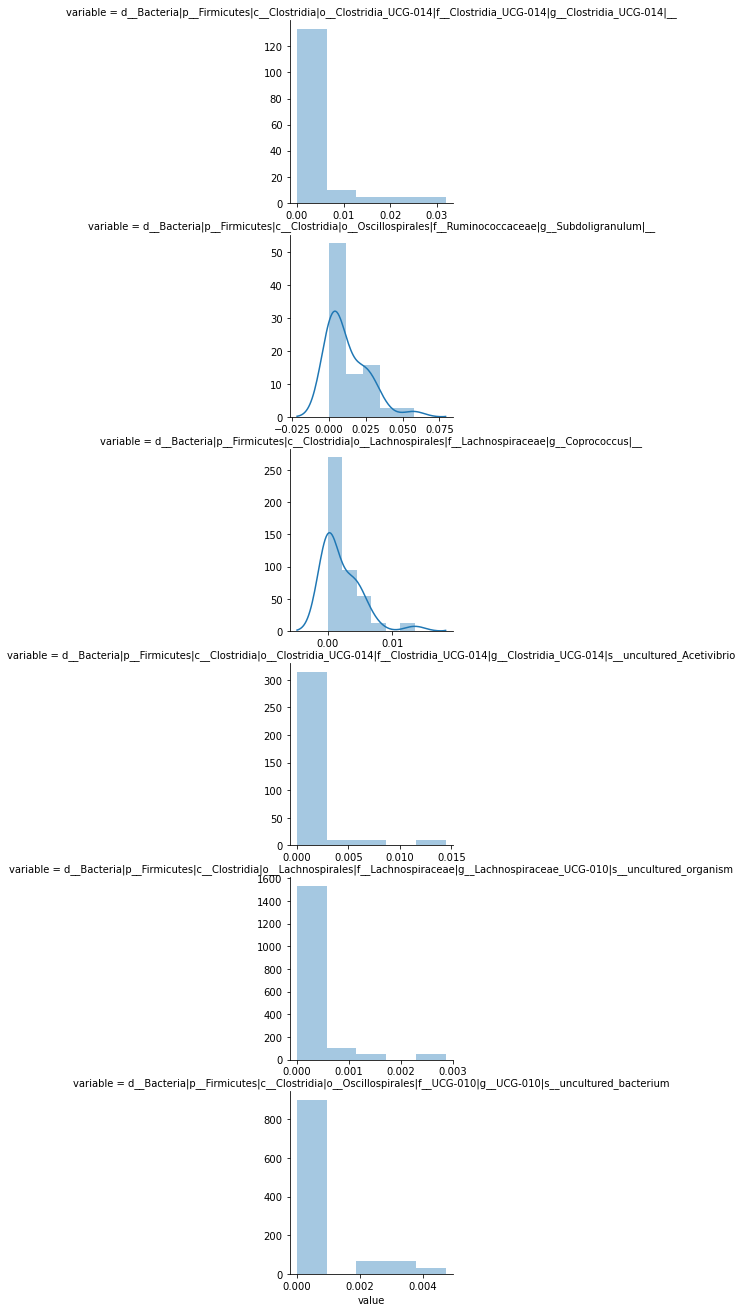

In [294]:
g = sns.FacetGrid(data=pd.melt(sharedtax),
                 row="variable",
                 sharex=False, sharey=False)
g.map(sns.distplot, "value")

In [259]:
sharedtax.head()

,d__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridia_UCG-014|f__Clostridia_UCG-014|g__Clostridia_UCG-014|__,d__Bacteria|p__Firmicutes|c__Clostridia|o__Oscillospirales|f__Ruminococcaceae|g__Subdoligranulum|__,d__Bacteria|p__Firmicutes|c__Clostridia|o__Oscillospirales|f__Ruminococcaceae|g__Subdoligranulum|__,d__Bacteria|p__Firmicutes|c__Clostridia|o__Lachnospirales|f__Lachnospiraceae|g__Coprococcus|__,d__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridia_UCG-014|f__Clostridia_UCG-014|g__Clostridia_UCG-014|s__uncultured_Acetivibrio,d__Bacteria|p__Firmicutes|c__Clostridia|o__Lachnospirales|f__Lachnospiraceae|g__Lachnospiraceae_UCG-010|s__uncultured_organism,d__Bacteria|p__Firmicutes|c__Clostridia|o__Oscillospirales|f__UCG-010|g__UCG-010|s__uncultured_bacterium
1.0,0.000000,0.024765,0.024765,0.000000,0.000000,0.000000,0.000000
10.0,0.009364,0.012088,0.012088,0.000000,0.000000,0.002867,0.000263
12.0,0.000000,0.007611,0.007611,0.000000,0.000000,0.000000,0.000000
14.0,0.000000,0.029268,0.029268,0.004873,0.000000,0.000000,0.002657
15.0,0.007849,0.015240,0.015240,0.004678,0.002817,0.000668,0.002844


In [297]:
for col in sharedtax.columns:
    print(col, "\n", stats.shapiro(sharedtax[col]))
    if stats.shapiro(sharedtax[col])[1] < 0.05:
        print("NOT NORMAL")

d__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridia_UCG-014|f__Clostridia_UCG-014|g__Clostridia_UCG-014|__ 
 (0.47539079189300537, 9.788240218355782e-10)
NOT NORMAL
d__Bacteria|p__Firmicutes|c__Clostridia|o__Oscillospirales|f__Ruminococcaceae|g__Subdoligranulum|__ 
 (0.8345869183540344, 0.00015873092343099415)
NOT NORMAL
d__Bacteria|p__Firmicutes|c__Clostridia|o__Lachnospirales|f__Lachnospiraceae|g__Coprococcus|__ 
 (0.7228899598121643, 1.4784276345380931e-06)
NOT NORMAL
d__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridia_UCG-014|f__Clostridia_UCG-014|g__Clostridia_UCG-014|s__uncultured_Acetivibrio 
 (0.3660242557525635, 8.020482888948521e-11)
NOT NORMAL
d__Bacteria|p__Firmicutes|c__Clostridia|o__Lachnospirales|f__Lachnospiraceae|g__Lachnospiraceae_UCG-010|s__uncultured_organism 
 (0.35966283082962036, 6.999809065710849e-11)
NOT NORMAL
d__Bacteria|p__Firmicutes|c__Clostridia|o__Oscillospirales|f__UCG-010|g__UCG-010|s__uncultured_bacterium 
 (0.5037287473678589, 1.980878350238413e-0

In [298]:
for col in sharedtax.columns:
    print("\n", col, "\n", stats.shapiro(sharedtax[col].apply(lambda x: np.arcsin(np.sqrt(x)))))
    if stats.shapiro(sharedtax[col])[1] < 0.05:
        print("NOT NORMAL")
    else:
        print("YES NORMAL")


 d__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridia_UCG-014|f__Clostridia_UCG-014|g__Clostridia_UCG-014|__ 
 (0.5384275913238525, 4.87499640655642e-09)
NOT NORMAL

 d__Bacteria|p__Firmicutes|c__Clostridia|o__Oscillospirales|f__Ruminococcaceae|g__Subdoligranulum|__ 
 (0.9291077256202698, 0.033006805926561356)
NOT NORMAL

 d__Bacteria|p__Firmicutes|c__Clostridia|o__Lachnospirales|f__Lachnospiraceae|g__Coprococcus|__ 
 (0.7705438733100891, 9.289971785619855e-06)
NOT NORMAL

 d__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridia_UCG-014|f__Clostridia_UCG-014|g__Clostridia_UCG-014|s__uncultured_Acetivibrio 
 (0.4300062656402588, 3.332186748750132e-10)
NOT NORMAL

 d__Bacteria|p__Firmicutes|c__Clostridia|o__Lachnospirales|f__Lachnospiraceae|g__Lachnospiraceae_UCG-010|s__uncultured_organism 
 (0.40219807624816895, 1.771552349261185e-10)
NOT NORMAL

 d__Bacteria|p__Firmicutes|c__Clostridia|o__Oscillospirales|f__UCG-010|g__UCG-010|s__uncultured_bacterium 
 (0.5495753288269043, 6.57242749113

In [304]:
for col in sharedtax.columns:
    print("\n", col, "\n", stats.shapiro(composition.clr(sharedtax[col].apply(lambda x: x+0.001))))
    if stats.shapiro(sharedtax[col])[1] < 0.05:
        print("NOT NORMAL")
    else:
        print("YES NORMAL")


 d__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridia_UCG-014|f__Clostridia_UCG-014|g__Clostridia_UCG-014|__ 
 (0.540542483329773, 5.157415827738987e-09)
NOT NORMAL

 d__Bacteria|p__Firmicutes|c__Clostridia|o__Oscillospirales|f__Ruminococcaceae|g__Subdoligranulum|__ 
 (0.8929839730262756, 0.0035207041073590517)
NOT NORMAL

 d__Bacteria|p__Firmicutes|c__Clostridia|o__Lachnospirales|f__Lachnospiraceae|g__Coprococcus|__ 
 (0.7638115882873535, 7.077144800859969e-06)
NOT NORMAL

 d__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridia_UCG-014|f__Clostridia_UCG-014|g__Clostridia_UCG-014|s__uncultured_Acetivibrio 
 (0.42386966943740845, 2.893411621407438e-10)
NOT NORMAL

 d__Bacteria|p__Firmicutes|c__Clostridia|o__Lachnospirales|f__Lachnospiraceae|g__Lachnospiraceae_UCG-010|s__uncultured_organism 
 (0.39432191848754883, 1.486720885290893e-10)
NOT NORMAL

 d__Bacteria|p__Firmicutes|c__Clostridia|o__Oscillospirales|f__UCG-010|g__UCG-010|s__uncultured_bacterium 
 (0.5243210792541504, 3.362811140

In [312]:
clr_sharedtax = pd.DataFrame(composition.clr(sharedtax.apply(lambda x: x+0.001)),
                            columns=sharedtax.columns,
                            index=sharedtax.index)

/opt/anaconda3/envs/qiime2-2020.6-NEW/lib/python3.6/site-packages/seaborn/axisgrid.py:856: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


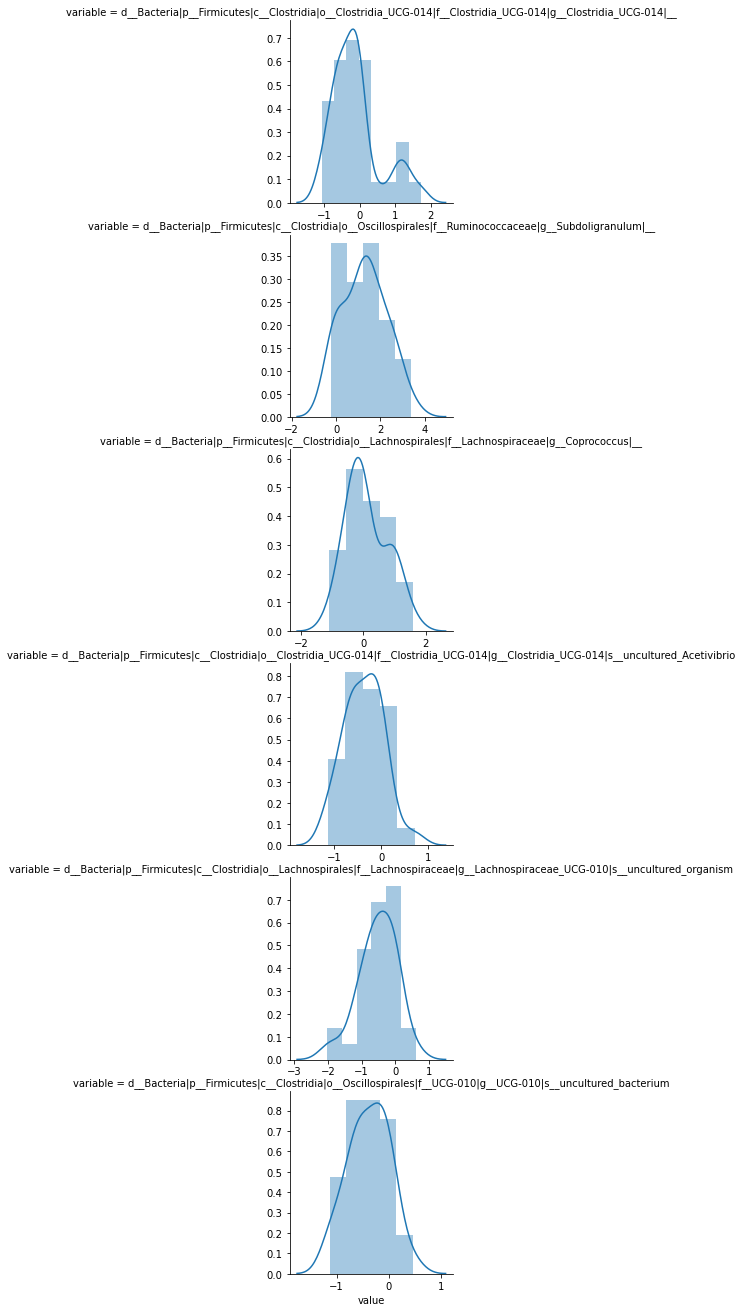

In [314]:
g = sns.FacetGrid(data=pd.melt(clr_sharedtax),
                 row="variable",
                 sharex=False, sharey=False)
g.map(sns.distplot, "value")
plt.show()

These may not pass shapiro-wilks, but they do look relatively normal based on the histograms! Much better than before.

In [316]:
clr_sharedtax.to_csv("clr_transformed_sharedtaxa.csv")

In [317]:
mapping

,barcodesequence,linkerprimersequence,study,plate.sample.id,plate.well.id,primer.plate,primer.well.id,body-site,date_collected,time_collected,...,fact_c_ab_8-cat,fact_c_ab_9-cat,fact_c_qol_1-cat,fact_c_qol_2-cat,fact_c_qol_3-cat,fact_c_qol_4-cat,Zpromis_Tscore_TOTAL,Zstress_scale_TOTAL,Zcesd_TOTAL,Zdistress_total
sampleid,,,,,,,,,,,,,,,,,,,,,
1.0,TAGACCGACTCC,AA,CU Denver BC Microbiome,1001-S1,A1,7.0,A1,gut,10/2/18,Not listed,...,Quite a bit,Quite a bit,A little bit,Not at all,Not at all,Not at all,1.47103,-0.01736,0.73560,2.19
3.0,TCCGACCCGATC,AA,CU Denver BC Microbiome,1005,C1,7.0,C1,gut,5/4/19,7:20 AM,...,Quite a bit,Quite a bit,Not at all,Not at all,Not at all,Not at all,0.49597,0.79283,0.36780,1.66
4.0,TCACTGCTAGGA,AA,CU Denver BC Microbiome,1006-S1,D1,7.0,D1,gut,2/23/18,6:35 AM,...,Very much,Very much,Not at all,Not at all,Not at all,Not at all,-0.65763,-0.62501,-1.22601,-2.51
6.0,AGCTATGTATGG,AA,CU Denver BC Microbiome,1007 - S1,F1,7.0,F1,gut,11/14/18,Not listed,...,Very much,Very much,Not at all,Not at all,Not at all,Not at all,0.27623,1.19793,1.96161,3.44
8.0,AAGGGTTAGTCT,AA,CU Denver BC Microbiome,1008-S1,H1,7.0,H1,gut,4/13/18,Not listed,...,Very much,Very much,A little bit,Not at all,Not at all,Not at all,-0.32803,-0.42246,0.00000,-0.75
10.0,TTCCCACCCATT,AA,CU Denver BC Microbiome,1009 - S1,B2,7.0,B2,gut,2/10/19,Not listed,...,Very much,Very much,Not at all,Not at all,Not at all,Not at all,-0.10830,-1.23265,-0.98081,-2.32
12.0,GGTCCTTCCCGA,AA,CU Denver BC Microbiome,1010-S1,D2,7.0,D2,gut,12/14/18,Not listed,...,Quite a bit,Somewhat,Somewhat,Somewhat,A little bit,A little bit,0.27623,-0.42246,-0.85821,-1.00
14.0,TTCCGAATCGGC,AA,CU Denver BC Microbiome,1011,F2,7.0,F2,gut,7/9/19,11:00 AM,...,Somewhat,Somewhat,Quite a bit,A little bit,A little bit,A little bit,-0.16323,-0.42246,-1.22601,-1.81
15.0,GCATGTCGAAAT,AA,CU Denver BC Microbiome,1012-S1,G2,7.0,G2,gut,1/1/19,Not listed,...,Very much,Very much,Not at all,Not at all,Not at all,Not at all,-0.46536,0.38774,-0.36780,-0.45


In [318]:
clr_sharedtax

,d__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridia_UCG-014|f__Clostridia_UCG-014|g__Clostridia_UCG-014|__,d__Bacteria|p__Firmicutes|c__Clostridia|o__Oscillospirales|f__Ruminococcaceae|g__Subdoligranulum|__,d__Bacteria|p__Firmicutes|c__Clostridia|o__Lachnospirales|f__Lachnospiraceae|g__Coprococcus|__,d__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridia_UCG-014|f__Clostridia_UCG-014|g__Clostridia_UCG-014|s__uncultured_Acetivibrio,d__Bacteria|p__Firmicutes|c__Clostridia|o__Lachnospirales|f__Lachnospiraceae|g__Lachnospiraceae_UCG-010|s__uncultured_organism,d__Bacteria|p__Firmicutes|c__Clostridia|o__Oscillospirales|f__UCG-010|g__UCG-010|s__uncultured_bacterium
1.0,-5.415050e-01,2.707525e+00,-5.415050e-01,-5.415050e-01,-5.415050e-01,-5.415050e-01
10.0,1.255748e+00,1.489045e+00,-1.082622e+00,-1.082622e+00,2.697615e-01,-8.493106e-01
12.0,-3.588361e-01,1.794180e+00,-3.588361e-01,-3.588361e-01,-3.588361e-01,-3.588361e-01
14.0,-1.079490e+00,2.330587e+00,6.908530e-01,-1.079490e+00,-1.079490e+00,2.170295e-01
15.0,5.299685e-01,1.137104e+00,8.625337e-02,-3.108075e-01,-1.138553e+00,-3.039656e-01
17.0,-7.529727e-01,1.179957e+00,6.160728e-01,-7.529727e-01,-7.529727e-01,4.628882e-01
19.0,-4.119888e-02,2.496783e+00,9.573956e-01,-1.137660e+00,-1.137660e+00,-1.137660e+00
21.0,-2.108002e-01,-2.108002e-01,1.054001e+00,-2.108002e-01,-2.108002e-01,-2.108002e-01
22.0,-1.831430e-01,9.157150e-01,-1.831430e-01,-1.831430e-01,-1.831430e-01,-1.831430e-01
23.0,-2.220446e-16,-2.220446e-16,-2.220446e-16,-2.220446e-16,-2.220446e-16,-2.220446e-16


In [321]:
clr_sharedtax["plate.sample.id"]= mapping["plate.sample.id"]
clr_sharedtax["hcvsbc-cat"]= mapping["hcvsbc-cat"]

In [322]:
clr_sharedtax

,d__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridia_UCG-014|f__Clostridia_UCG-014|g__Clostridia_UCG-014|__,d__Bacteria|p__Firmicutes|c__Clostridia|o__Oscillospirales|f__Ruminococcaceae|g__Subdoligranulum|__,d__Bacteria|p__Firmicutes|c__Clostridia|o__Lachnospirales|f__Lachnospiraceae|g__Coprococcus|__,d__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridia_UCG-014|f__Clostridia_UCG-014|g__Clostridia_UCG-014|s__uncultured_Acetivibrio,d__Bacteria|p__Firmicutes|c__Clostridia|o__Lachnospirales|f__Lachnospiraceae|g__Lachnospiraceae_UCG-010|s__uncultured_organism,d__Bacteria|p__Firmicutes|c__Clostridia|o__Oscillospirales|f__UCG-010|g__UCG-010|s__uncultured_bacterium,plate.sample.id,hcvsbc-cat
1.0,-5.415050e-01,2.707525e+00,-5.415050e-01,-5.415050e-01,-5.415050e-01,-5.415050e-01,1001-S1,1 - Yes
10.0,1.255748e+00,1.489045e+00,-1.082622e+00,-1.082622e+00,2.697615e-01,-8.493106e-01,1009 - S1,2 - No
12.0,-3.588361e-01,1.794180e+00,-3.588361e-01,-3.588361e-01,-3.588361e-01,-3.588361e-01,1010-S1,2 - No
14.0,-1.079490e+00,2.330587e+00,6.908530e-01,-1.079490e+00,-1.079490e+00,2.170295e-01,1011,1 - Yes
15.0,5.299685e-01,1.137104e+00,8.625337e-02,-3.108075e-01,-1.138553e+00,-3.039656e-01,1012-S1,2 - No
17.0,-7.529727e-01,1.179957e+00,6.160728e-01,-7.529727e-01,-7.529727e-01,4.628882e-01,1013 - S1,1 - Yes
19.0,-4.119888e-02,2.496783e+00,9.573956e-01,-1.137660e+00,-1.137660e+00,-1.137660e+00,1015-S1,2 - No
21.0,-2.108002e-01,-2.108002e-01,1.054001e+00,-2.108002e-01,-2.108002e-01,-2.108002e-01,1017,1 - Yes
22.0,-1.831430e-01,9.157150e-01,-1.831430e-01,-1.831430e-01,-1.831430e-01,-1.831430e-01,1018,1 - Yes
23.0,-2.220446e-16,-2.220446e-16,-2.220446e-16,-2.220446e-16,-2.220446e-16,-2.220446e-16,1020,1 - Yes


In [323]:
clr_sharedtax.to_csv("clr_transformed_sharedtaxa_2.csv")